In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
data_path = "/content/drive/MyDrive/TMP/TMP_Recommendation_SystemAnalysis&Modeling_Data"

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [38]:
categories = pd.read_csv(f'{data_path}/category_tree.csv')
events = pd.read_csv(f'{data_path}/events.csv')
item_props_part1 = pd.read_csv(f'{data_path}/item_properties_part1.csv')
item_props_part2 = pd.read_csv(f'{data_path}/item_properties_part2.csv')

In [39]:
# Combine item properties files
item_properties = pd.concat([item_props_part1, item_props_part2], ignore_index=True)

In [40]:
# events data
print(f"Events data loaded: {events.shape}")
print(f"Columns: {list(events.columns)}")
print("\nFirst few rows of events:")
print(events.head())

Events data loaded: (2756101, 5)
Columns: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

First few rows of events:
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN


In [41]:
# Load category data
print(f"\nCategory data loaded: {categories.shape}")
print(f"Columns: {list(categories.columns)}")
print("\nFirst few rows of category:")
print(categories.head())


Category data loaded: (1669, 2)
Columns: ['categoryid', 'parentid']

First few rows of category:
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0


In [42]:
# Check columns (note: should be timestamp, itemid, property, value)
print(f"\nItem Properties data loaded: {item_properties.shape}")
print(f"Columns: {list(item_properties.columns)}")
print("\nFirst few rows:")
print(item_properties.head())


Item Properties data loaded: (20275902, 4)
Columns: ['timestamp', 'itemid', 'property', 'value']

First few rows:
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513


## DATA QUALITY ASSESSMENT

In [43]:
# 1. Missing Values Analysis
print("1. Missing Values Analysis:")
missing_analysis = {
    'events': events.isnull().sum(),
    'item_properties': item_properties.isnull().sum(),
    'categories': categories.isnull().sum()
}

for dataset, missing in missing_analysis.items():
    print(f"\n{dataset.upper()}:")
    for col, count in missing.items():
        if count > 0:
            pct = (count / len(eval(dataset))) * 100
            print(f"  {col}: {count:,} ({pct:.2f}%)")

1. Missing Values Analysis:

EVENTS:
  transactionid: 2,733,644 (99.19%)

ITEM_PROPERTIES:

CATEGORIES:
  parentid: 25 (1.50%)


In [44]:
# 2. Data Consistency Checks
print("\n2. Data Consistency Analysis:")

# Check for orphaned items (items in events but not in properties)
items_in_events = set(events['itemid'].unique())
items_in_props = set(item_properties['itemid'].unique())
orphaned_items = items_in_events - items_in_props
coverage = len(items_in_props & items_in_events) / len(items_in_events)

print(f"Items in events: {len(items_in_events):,}")
print(f"Items with properties: {len(items_in_props):,}")
print(f"Property coverage: {coverage:.2%}")
print(f"Orphaned items: {len(orphaned_items):,}")


2. Data Consistency Analysis:
Items in events: 235,061
Items with properties: 417,053
Property coverage: 78.81%
Orphaned items: 49,815


In [45]:
# 3. Temporal Analysis
print("\n3. Temporal Data Quality:")

# Convert timestamps to datetime objects (assuming they are in milliseconds)
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms')

event_date_range = events['timestamp'].max() - events['timestamp'].min()
prop_date_range = item_properties['timestamp'].max() - item_properties['timestamp'].min()

print(f"Events date range: {event_date_range.days} days")
print(f"Properties date range: {prop_date_range.days} days")


3. Temporal Data Quality:
Events date range: 137 days
Properties date range: 126 days


## BUSINESS QUESTIONS AND VISUALIZATIONS

BUSINESS AREAS TO EXPLORE FOR ANALYSIS:

1.   ***User Engagement Patterns***

*   How is the daily activity of users like?
*   What is the hourly trend in users activity?
*   What is the major event category of users on the platform?


2.   ***User Conversion Funnel***
*   What is the user conversion funnel on the like?
*   What is the rate of users purchase to the total user visits?


3.   ***Item Performance Analysis***
*   What Items has the most views?
*   What is the correlation between the item views and the item purchases?


1. USER ENGAGEMENT PATTERNS


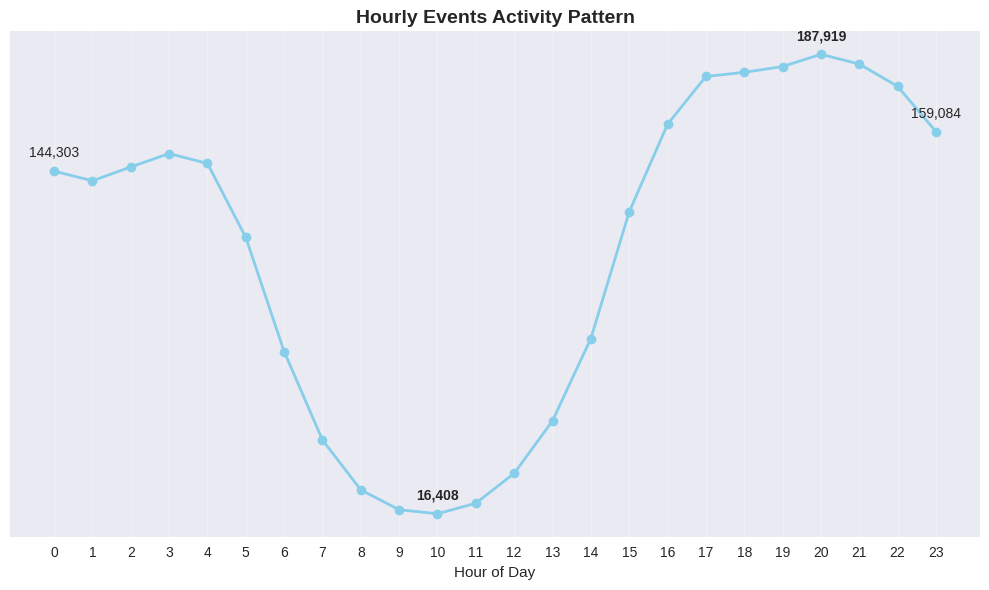

In [46]:
# Business Question 1: User Engagement Patterns
print("\n1. USER ENGAGEMENT PATTERNS")

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Hourly activity pattern
events['hour'] = events['timestamp'].dt.hour
hourly_activity = events.groupby('hour')['event'].count()

# Plot the line
axes.plot(hourly_activity.index, hourly_activity.values, marker='o', linewidth=2, color='skyblue') # Keep the line color

axes.set_title('Hourly Events Activity Pattern', fontsize=14, fontweight='bold')
axes.set_xlabel('Hour of Day')
axes.set_ylabel('Number of Events')
axes.grid(True, alpha=0.3)

axes.set_xticks(range(0, 24, 1))

# Add data labels
# Beginning
axes.annotate(f'{hourly_activity.iloc[0]:,}', (hourly_activity.index[0], hourly_activity.iloc[0]), textcoords="offset points", xytext=(0,10), ha='center')
# End
axes.annotate(f'{hourly_activity.iloc[-1]:,}', (hourly_activity.index[-1], hourly_activity.iloc[-1]), textcoords="offset points", xytext=(0,10), ha='center')
# Peak
peak_hour = hourly_activity.idxmax()
peak_value = hourly_activity.max()
axes.annotate(f'{peak_value:,}', (peak_hour, peak_value), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
# Low
low_hour = hourly_activity.idxmin()
low_value = hourly_activity.min()
axes.annotate(f'{low_value:,}', (low_hour, low_value), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')

axes.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

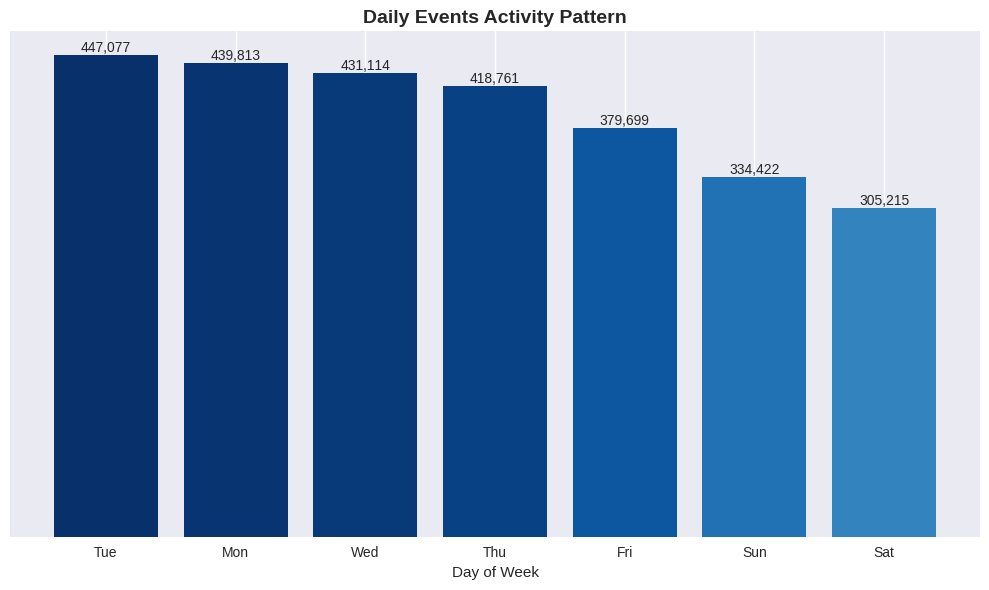

In [47]:
# Daily activity pattern
events['day_of_week'] = events['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
daily_activity = events.groupby('day_of_week')['event'].count()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Arrange in ascending order and map day names
daily_activity = daily_activity.sort_values(ascending=False)
sorted_days = [days[i] for i in daily_activity.index]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

cmap = plt.cm.get_cmap('Blues')
colors = cmap(daily_activity.values / daily_activity.max())

bars = ax.bar(range(7), daily_activity.values, color=colors)
ax.set_title('Daily Events Activity Pattern', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Events')
ax.set_xticks(range(7))
ax.set_xticklabels(sorted_days)

# Add data labels to all bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,}', va='bottom', ha='center') # Use va='bottom' and adjust position slightly

ax.yaxis.set_visible(False)


plt.tight_layout()
plt.show()

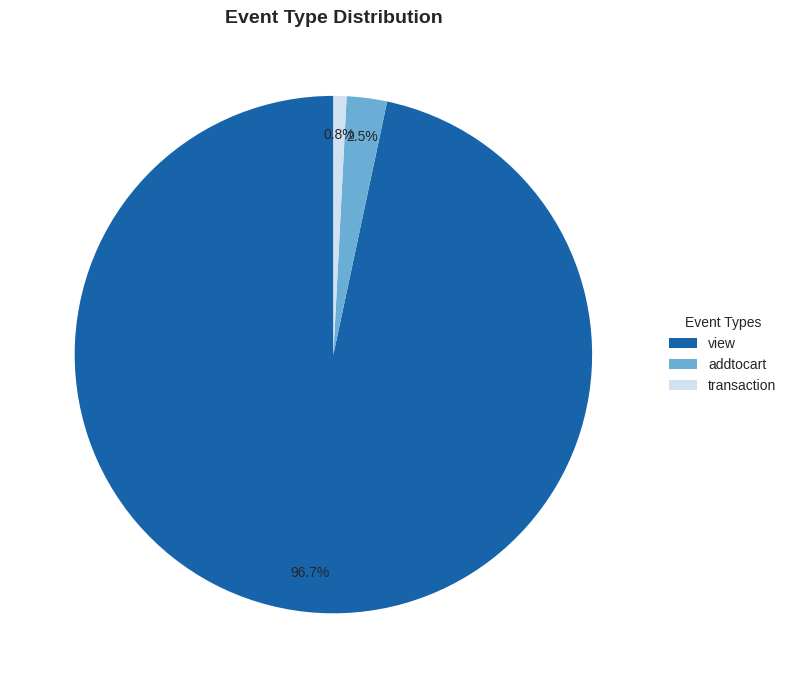

In [48]:
# Event type distribution
event_counts = events['event'].value_counts()

# Define colors based on the sorted event counts
sorted_events = event_counts.sort_values(ascending=False)
cmap = plt.cm.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.8, len(sorted_events)))

# Swap colors for the highest (first) and lowest (last) slices
if len(colors) >= 2:
    colors[[0, -1]] = colors[[-1, 0]]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
wedges, texts, autotexts = ax.pie(sorted_events.values, autopct='%1.1f%%',
                                  colors=colors, startangle=90, pctdistance=0.85)
ax.set_title('Event Type Distribution', fontsize=14, fontweight='bold')

# Add a legend
ax.legend(wedges, sorted_events.index, title="Event Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

### Business Question 2: Conversion Funnel Analysis
 CONVERSION FUNNEL ANALYSIS

In [49]:
# Calculate funnel metrics
total_users = events['visitorid'].nunique()
viewers = events[events['event'] == 'view']['visitorid'].nunique()
cart_users = events[events['event'] == 'addtocart']['visitorid'].nunique()
buyers = events[events['event'] == 'transaction']['visitorid'].nunique()

funnel_data = {
    'Stage': ['Total Visitors', 'Viewers', 'Add to Cart', 'Purchasers'],
    'Users': [total_users, viewers, cart_users, buyers],
    'Conversion_Rate': [100, (viewers/total_users)*100,
                       (cart_users/total_users)*100, (buyers/total_users)*100]
}

funnel_df = pd.DataFrame(funnel_data)

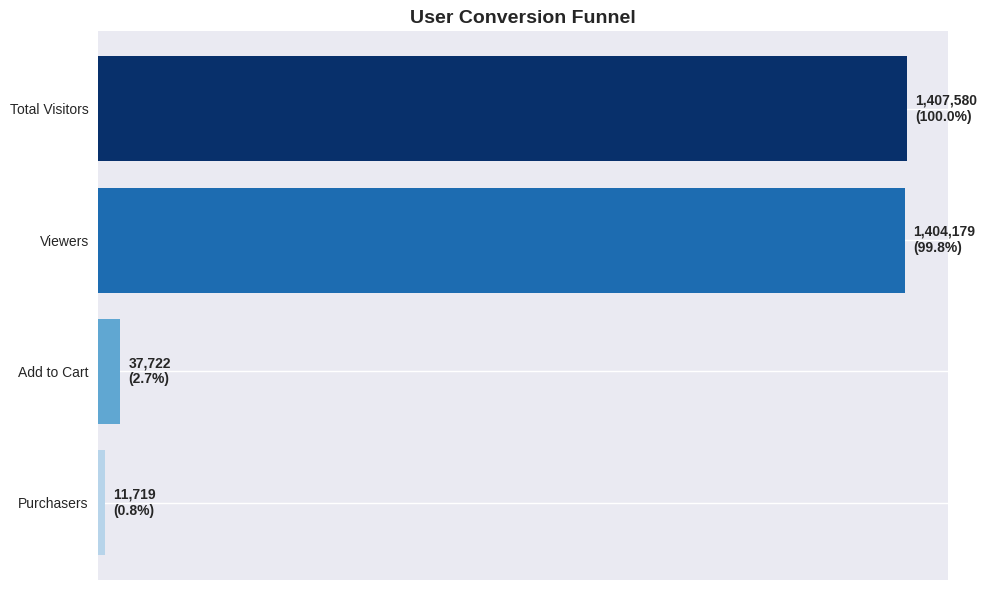

In [50]:
# Funnel visualization
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Reverse the order of the DataFrame for plotting
funnel_df_reversed = funnel_df.iloc[::-1].reset_index(drop=True)

cmap = plt.cm.get_cmap('Blues')
colors = cmap(np.linspace(0.3, 1.0, len(funnel_df_reversed)))

ax1.barh(funnel_df_reversed['Stage'], funnel_df_reversed['Users'], color=colors)
ax1.set_title('User Conversion Funnel', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Users')

# Add percentage labels
for i, (users, rate) in enumerate(zip(funnel_df_reversed['Users'], funnel_df_reversed['Conversion_Rate'])):
    ax1.text(users + total_users*0.01, i, f'{users:,}\n({rate:.1f}%)',
             va='center', fontweight='bold')

ax1.xaxis.set_visible(False)

plt.tight_layout()
plt.show()

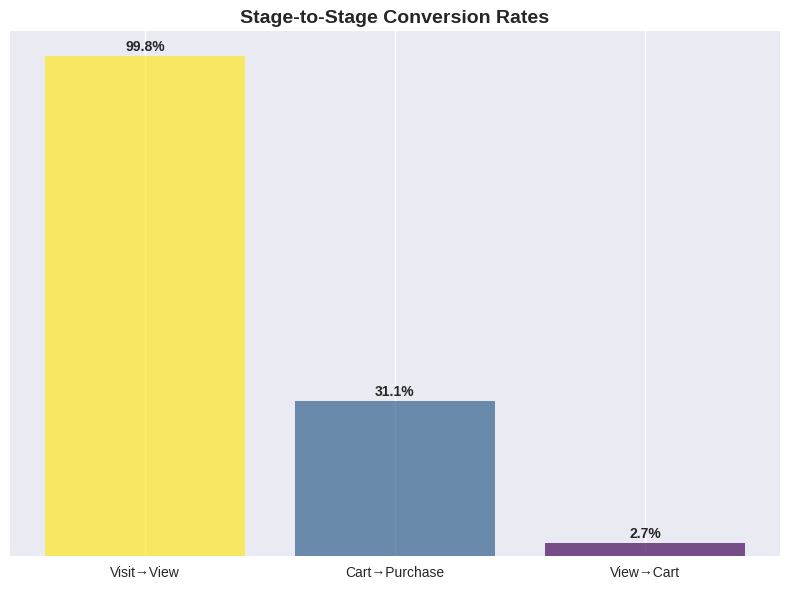

In [51]:
# Conversion rates between stages
stage_conversions = [
    (viewers/total_users)*100,
    (cart_users/viewers)*100 if viewers > 0 else 0,
    (buyers/cart_users)*100 if cart_users > 0 else 0
]
labels = ['Visit→View', 'View→Cart', 'Cart→Purchase']

# Combine and sort data in descending order
sorted_conversions = sorted(zip(stage_conversions, labels), reverse=True)
sorted_rates = [rate for rate, label in sorted_conversions]
sorted_labels = [label for rate, label in sorted_conversions]

fig, ax2 = plt.subplots(1, 1, figsize=(8, 6))

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.array(sorted_rates) / max(sorted_rates)) # Convert sorted_rates to NumPy array

ax2.bar(sorted_labels, sorted_rates, color=colors, alpha=0.7)
ax2.set_title('Stage-to-Stage Conversion Rates', fontsize=14, fontweight='bold')
ax2.set_ylabel('Conversion Rate (%)')
# Add value labels on bars
for i, v in enumerate(sorted_rates):
    ax2.text(i, v + max(sorted_rates)*0.01, f'{v:.1f}%',
             ha='center', fontweight='bold')

ax2.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Business Question 3: Item Performance Analysis
ITEM PERFORMANCE ANALYSIS

In [52]:
# Get item metrics
item_metrics = events.groupby('itemid').agg({
    'event': 'count',
    'visitorid': 'nunique'
}).rename(columns={'event': 'total_interactions', 'visitorid': 'unique_visitors'})

# Add event-specific metrics
item_views = events[events['event'] == 'view'].groupby('itemid').size()
item_carts = events[events['event'] == 'addtocart'].groupby('itemid').size()
item_purchases = events[events['event'] == 'transaction'].groupby('itemid').size()

item_metrics['views'] = item_views
item_metrics['carts'] = item_carts
item_metrics['purchases'] = item_purchases
item_metrics = item_metrics.fillna(0)

# Calculate conversion rates
# Add a small epsilon to the denominator to avoid division by zero
epsilon = 1e-9
item_metrics['view_to_cart_rate'] = (item_metrics['carts'] / (item_metrics['views'] + epsilon)).fillna(0)
item_metrics['cart_to_purchase_rate'] = (item_metrics['purchases'] / (item_metrics['carts'] + epsilon)).fillna(0)
item_metrics['overall_conversion'] = (item_metrics['purchases'] / (item_metrics['views'] + epsilon)).fillna(0)

# Performance categories
item_metrics['performance_category'] = pd.cut(item_metrics['overall_conversion'],
                                            bins=[0, 0.01, 0.05, 0.1, 1.0],
                                            labels=['Low', 'Medium', 'High', 'Excellent'])

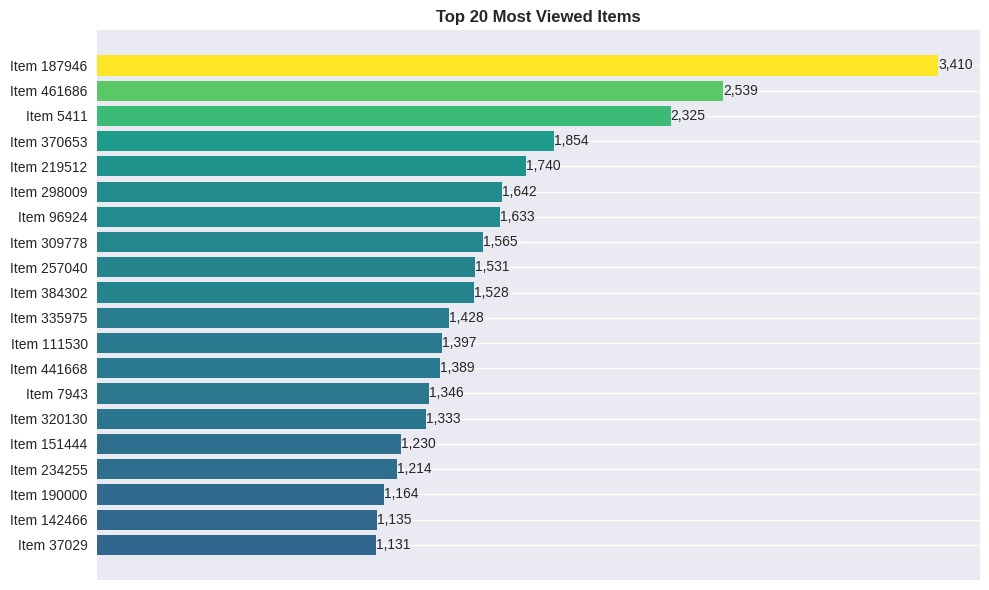

In [53]:
# Top performing items by views
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
top_viewed = item_metrics.nlargest(20, 'views')

cmap = plt.cm.get_cmap('viridis') ap
colors = cmap(top_viewed['views'].values / top_viewed['views'].max())

bars = ax.barh(range(len(top_viewed)), top_viewed['views'].values, color=colors) # Store bars to add labels
ax.set_title('Top 20 Most Viewed Items', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Views') s
ax.set_yticks(range(len(top_viewed)))
ax.set_yticklabels([f'Item {idx}' for idx in top_viewed.index])
ax.invert_yaxis()

# Add data labels to all bars
for bar in bars:
    xval = bar.get_width()
    ax.text(xval, bar.get_y() + bar.get_height()/2, f'{int(xval):,}', va='center', ha='left') # Use ha='left' and adjust position slightly

ax.xaxis.set_visible(False)

plt.tight_layout()
plt.show()

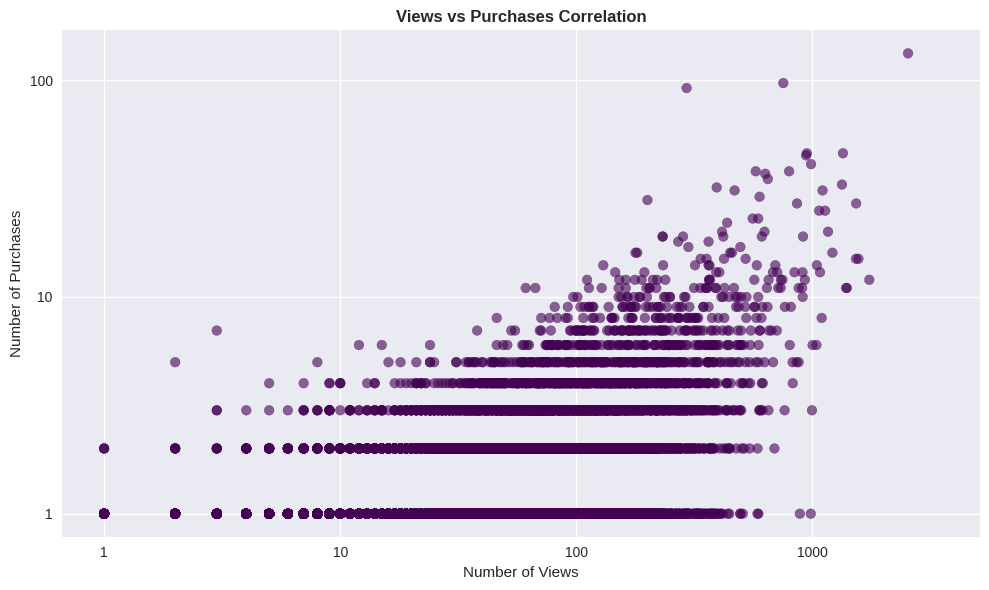

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Views vs Purchases scatter
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scatter = ax.scatter(item_metrics['views'], item_metrics['purchases'],
                   c=item_metrics['overall_conversion'], cmap='viridis', alpha=0.6) # Color points by overall_conversion
ax.set_title('Views vs Purchases Correlation', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Views')
ax.set_ylabel('Number of Purchases')
ax.set_xscale('log')
ax.set_yscale('log')

# Format tick labels for better readability
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()

**Views vs Purchases Correlation**

This scatter plot visualizes the relationship between the number of times an item was viewed and the number of times it was purchased. Each point represents a unique item.

*   **Logarithmic Scale:** Both the x-axis (Views) and y-axis (Purchases) are on a logarithmic scale. This is useful because the number of views and purchases can vary greatly between items. The logarithmic scale helps to spread out the data points and reveal patterns that might be hidden on a linear scale, especially for items with high view or purchase counts.

*   **Insights:** Items appearing towards the upper right of the plot have both high views and high purchases, indicating popular and well-converting items. Items towards the lower left have low views and low purchases. Items in the upper left (high views, low purchases) might indicate issues with the item itself, pricing, or the conversion path. Items in the lower right (low views, high purchases) might be niche items or have highly effective marketing.

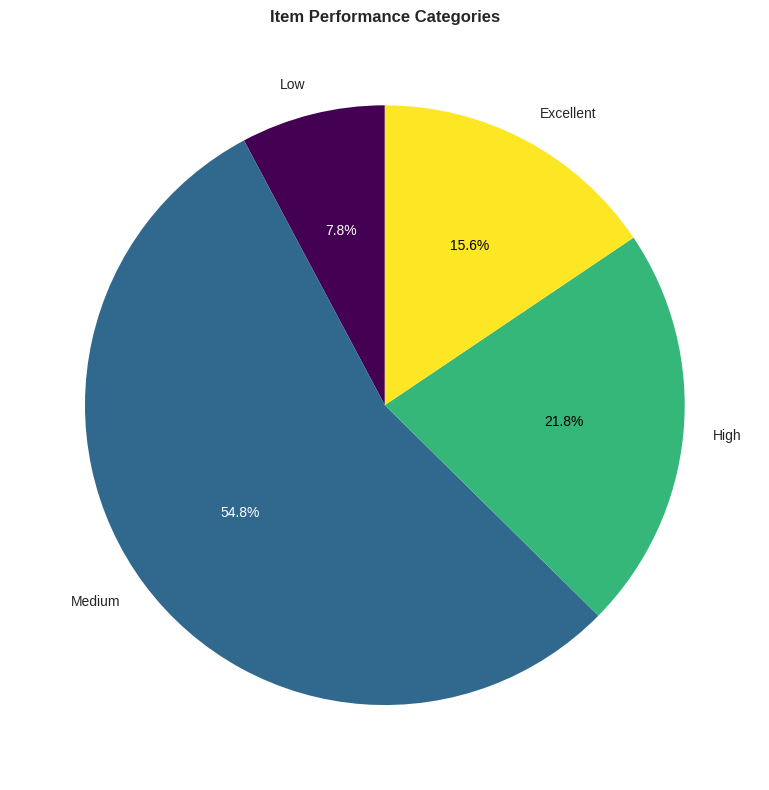

In [55]:
# Item Performance Categories pie chart
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
perf_counts = item_metrics['performance_category'].value_counts()

# Sort the categories for consistent color mapping
sorted_categories = ['Low', 'Medium', 'High', 'Excellent']
sorted_counts = perf_counts.reindex(sorted_categories)

# Use a colormap for the pie slices
cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(sorted_categories)))

wedges, texts, autotexts = ax.pie(sorted_counts.values, labels=sorted_counts.index, autopct='%1.1f%%',
                                  colors=colors, startangle=90)
ax.set_title('Item Performance Categories', fontsize=12, fontweight='bold')

# Adjust label colors based on slice color for better contrast
for i, autotext in enumerate(autotexts):
    # Get the color of the wedge corresponding to this autotext
    wedge_color = wedges[i].get_facecolor()
    # For RGB colors in the range 0-1
    brightness = (0.299 * wedge_color[0] + 0.587 * wedge_color[1] + 0.114 * wedge_color[2])
    # Set text color to white for dark colors (brightness < 0.5) and black for light colors
    if brightness < 0.5:
        autotext.set_color('white')
    else:
        autotext.set_color('black')


plt.tight_layout()
plt.show()

**Item Performance Categories Explained:**

The item performance categories are defined based on the `overall_conversion` rate (Purchases / Views) as follows:

*   **Low:** Overall Conversion Rate between 0% and 1%
*   **Medium:** Overall Conversion Rate between 1% and 5%
*   **High:** Overall Conversion Rate between 5% and 10%
*   **Excellent:** Overall Conversion Rate between 10% and 100%

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [57]:
np.random.seed(42)

# ADAPTIVE sampling based on data characteristics
print("Analyzing data distribution...")

# First, understand the data structure
user_counts = events.groupby('visitorid').size().sort_values(ascending=False)
item_counts = events.groupby('itemid').size().sort_values(ascending=False)

print(f"Total users: {len(user_counts):,}")
print(f"Total items: {len(item_counts):,}")
print(f"Total interactions: {len(events):,}")
print(f"Users with 1 interaction: {(user_counts == 1).sum():,}")
print(f"Users with 2+ interactions: {(user_counts >= 2).sum():,}")
print(f"Users with 3+ interactions: {(user_counts >= 3).sum():,}")

# FLEXIBLE sampling strategy
if (user_counts >= 2).sum() >= 1000:
    # If we have enough users with 2+ interactions
    min_user_interactions = 2
    target_users = 2000
    target_items = 1500
elif (user_counts >= 1).sum() >= 2000:
    # If we have many users with 1+ interactions
    min_user_interactions = 1
    target_users = 3000
    target_items = 2000
else:
    # Very sparse data - be more lenient
    min_user_interactions = 1
    target_users = min(5000, len(user_counts))
    target_items = min(3000, len(item_counts))

print(f"\nUsing adaptive strategy:")
print(f"✓ Minimum user interactions: {min_user_interactions}")
print(f"✓ Target users: {target_users}")
print(f"✓ Target items: {target_items}")

# Select users and items
selected_users = user_counts[user_counts >= min_user_interactions].head(target_users).index
selected_items = item_counts.head(target_items).index

# Create sample with selected users and items
events_sample = events[
    (events['visitorid'].isin(selected_users)) &
    (events['itemid'].isin(selected_items))
]

# If still too small, expand the sample
if len(events_sample) < 5000:
    print(" Small sample detected. Expanding...")
    # Take top interactions without strict filtering
    events_sample = events.sample(n=min(15000, len(events)), random_state=42)

print(f"✓ Final sample: {len(events_sample):,} interactions")
print(f"✓ Users: {events_sample['visitorid'].nunique():,}")
print(f"✓ Items: {events_sample['itemid'].nunique():,}")
print(f"✓ Events distribution:")
print(events_sample['event'].value_counts())

Analyzing data distribution...
Total users: 1,407,580
Total items: 235,061
Total interactions: 2,756,101
Users with 1 interaction: 1,001,560
Users with 2+ interactions: 406,020
Users with 3+ interactions: 200,028

Using adaptive strategy:
✓ Minimum user interactions: 2
✓ Target users: 2000
✓ Target items: 1500
✓ Final sample: 46,300 interactions
✓ Users: 1,556
✓ Items: 1,374
✓ Events distribution:
event
view           40975
addtocart       3331
transaction     1994
Name: count, dtype: int64


In [58]:
#  CREATE INTERACTION MATRIX WITH IMPLICIT FEEDBACK
print("CREATING INTERACTION MATRIX - IMPLICIT FEEDBACK APPROACH")

# Use implicit feedback approach - better for sparse data
# Count interactions rather than weighted ratings
interactions = events_sample.groupby(['visitorid', 'itemid']).size().reset_index(name='interaction_count')

# Apply log transformation to reduce skew
interactions['implicit_rating'] = np.log1p(interactions['interaction_count'])

print(f"✓ Unique user-item pairs: {len(interactions):,}")
print(f"✓ Interaction count distribution:")
print(interactions['interaction_count'].describe())

# Create user-item matrix
user_item_matrix = interactions.pivot(
    index='visitorid',
    columns='itemid',
    values='implicit_rating'
).fillna(0)

# Calculate sparsity
total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
non_zero_cells = (user_item_matrix > 0).sum().sum()
sparsity = (1 - non_zero_cells / total_cells) * 100

print(f"✓ Matrix shape: {user_item_matrix.shape}")
print(f"✓ Non-zero entries: {non_zero_cells:,}")
print(f"✓ Sparsity: {sparsity:.1f}%")
print(f"✓ Average interactions per user: {len(interactions) / user_item_matrix.shape[0]:.1f}")


CREATING INTERACTION MATRIX - IMPLICIT FEEDBACK APPROACH
✓ Unique user-item pairs: 18,379
✓ Interaction count distribution:
count    18379.000000
mean         2.519179
std          6.447069
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        308.000000
Name: interaction_count, dtype: float64
✓ Matrix shape: (1556, 1374)
✓ Non-zero entries: 18,379
✓ Sparsity: 99.1%
✓ Average interactions per user: 11.8


In [59]:
#  INTELLIGENT TRAIN-TEST SPLIT
print("INTELLIGENT TRAIN-TEST SPLIT")

def create_temporal_split(events_df, test_ratio=0.2):
    """Create temporal train-test split when possible"""
    try:
        # Try temporal split if timestamp exists
        if 'timestamp' in events_df.columns:
            events_sorted = events_df.sort_values('timestamp')
            split_point = int(len(events_sorted) * (1 - test_ratio))
            train_events = events_sorted.iloc[:split_point]
            test_events = events_sorted.iloc[split_point:]
            return train_events, test_events
    except:
        pass

    # Fallback to random split
    return train_test_split(events_df, test_size=test_ratio, random_state=42)

# Create train-test split from events
train_events, test_events = create_temporal_split(events_sample)

# Create interaction matrices for train and test
train_interactions = train_events.groupby(['visitorid', 'itemid']).size().reset_index(name='interaction_count')
train_interactions['implicit_rating'] = np.log1p(train_interactions['interaction_count'])

test_interactions = test_events.groupby(['visitorid', 'itemid']).size().reset_index(name='interaction_count')
test_interactions['implicit_rating'] = np.log1p(test_interactions['interaction_count'])

# Create training matrix
train_matrix = train_interactions.pivot(
    index='visitorid',
    columns='itemid',
    values='implicit_rating'
).fillna(0)

print(f"✓ Training interactions: {len(train_interactions):,}")
print(f"✓ Test interactions: {len(test_interactions):,}")
print(f"✓ Training matrix: {train_matrix.shape}")

# Find common users for evaluation
test_users = set(test_interactions['visitorid'].unique())
train_users = set(train_matrix.index)
common_users = test_users.intersection(train_users)
print(f"✓ Users in both train/test: {len(common_users):,}")


INTELLIGENT TRAIN-TEST SPLIT
✓ Training interactions: 14,935
✓ Test interactions: 3,907
✓ Training matrix: (1361, 1354)
✓ Users in both train/test: 292


In [60]:
#  ENHANCED POPULARITY MODEL
print("MODEL 1: ENHANCED POPULARITY RECOMMENDER")

class EnhancedPopularityRecommender:
    def __init__(self):
        self.item_stats = None
        self.popularity_scores = None

    def fit(self, interactions_df):
        """Calculate popularity using multiple signals"""
        # Calculate comprehensive item statistics
        self.item_stats = interactions_df.groupby('itemid').agg({
            'implicit_rating': ['sum', 'mean', 'count'],
            'visitorid': 'nunique'
        }).reset_index()

        # Flatten column names
        self.item_stats.columns = ['itemid', 'total_rating', 'avg_rating', 'interaction_count', 'unique_users']

        # Calculate popularity score using multiple factors
        # Wilson score for confidence intervals
        self.item_stats['popularity_score'] = (
            self.item_stats['total_rating'] *
            np.sqrt(self.item_stats['unique_users']) *
            np.log1p(self.item_stats['interaction_count'])
        )

        self.popularity_scores = self.item_stats.sort_values('popularity_score', ascending=False)
        print(f"✓ Trained on {len(self.popularity_scores)} items")
        print(f"✓ Top item: {self.popularity_scores.iloc[0]['itemid']} (score: {self.popularity_scores.iloc[0]['popularity_score']:.1f})")

    def recommend(self, user_id=None, n_recommendations=10, exclude_seen=None):
        recommendations = self.popularity_scores['itemid'].tolist()
        if exclude_seen:
            recommendations = [item for item in recommendations if item not in exclude_seen]
        return recommendations[:n_recommendations]

popularity_model = EnhancedPopularityRecommender()
popularity_model.fit(train_interactions)

MODEL 1: ENHANCED POPULARITY RECOMMENDER
✓ Trained on 1354 items
✓ Top item: 119736.0 (score: 5897.8)


In [61]:
#  NEIGHBORHOOD-BASED MODEL (USER OR ITEM BASED)
print("MODEL 2: ADAPTIVE NEIGHBORHOOD-BASED CF")

class AdaptiveNeighborhoodCF:
    def __init__(self, n_neighbors=50):
        self.n_neighbors = n_neighbors
        self.similarity_matrix = None
        self.train_matrix = None
        self.approach = None

    def fit(self, train_matrix):
        self.train_matrix = train_matrix

        # Decide whether to use user-based or item-based approach
        n_users, n_items = train_matrix.shape

        if n_users <= n_items:
            self.approach = "user-based"
            print(f"✓ Using user-based approach ({n_users} users vs {n_items} items)")
            self._fit_user_based()
        else:
            self.approach = "item-based"
            print(f"✓ Using item-based approach ({n_items} items vs {n_users} users)")
            self._fit_item_based()

    def _fit_user_based(self):
        """Fit user-based collaborative filtering"""
        # Use only active users to reduce computation
        user_activity = (self.train_matrix > 0).sum(axis=1)
        top_users = user_activity.nlargest(min(500, len(user_activity))).index
        subset_matrix = self.train_matrix.loc[top_users]

        # Calculate user similarity
        user_sim = cosine_similarity(subset_matrix.values)
        np.fill_diagonal(user_sim, 0)

        self.similarity_matrix = pd.DataFrame(
            user_sim, index=subset_matrix.index, columns=subset_matrix.index
        )
        print(f"✓ User similarity matrix: {self.similarity_matrix.shape}")

    def _fit_item_based(self):
        """Fit item-based collaborative filtering"""
        # Use only popular items to reduce computation
        item_activity = (self.train_matrix > 0).sum(axis=0)
        top_items = item_activity.nlargest(min(800, len(item_activity))).index
        subset_matrix = self.train_matrix[top_items].T

        # Calculate item similarity
        item_sim = cosine_similarity(subset_matrix.values)
        np.fill_diagonal(item_sim, 0)

        self.similarity_matrix = pd.DataFrame(
            item_sim, index=subset_matrix.index, columns=subset_matrix.index
        )
        print(f"✓ Item similarity matrix: {self.similarity_matrix.shape}")

    def recommend(self, user_id, n_recommendations=10):
        if user_id not in self.train_matrix.index:
            return []

        if self.approach == "user-based":
            return self._recommend_user_based(user_id, n_recommendations)
        else:
            return self._recommend_item_based(user_id, n_recommendations)

    def _recommend_user_based(self, user_id, n_recommendations):
        if user_id not in self.similarity_matrix.index:
            return []

        # Find similar users
        similar_users = self.similarity_matrix.loc[user_id].sort_values(ascending=False)
        user_items = set(self.train_matrix.loc[user_id][self.train_matrix.loc[user_id] > 0].index)

        recommendations = {}
        for similar_user, similarity in similar_users.head(self.n_neighbors).items():
            if similarity > 0.1:  # Minimum similarity threshold
                similar_user_items = self.train_matrix.loc[similar_user]
                for item_id, rating in similar_user_items[similar_user_items > 0].items():
                    if item_id not in user_items:
                        recommendations[item_id] = recommendations.get(item_id, 0) + similarity * rating

        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in sorted_recs[:n_recommendations]]

    def _recommend_item_based(self, user_id, n_recommendations):
        user_ratings = self.train_matrix.loc[user_id]
        user_items = user_ratings[user_ratings > 0]

        recommendations = {}
        for item_id, rating in user_items.items():
            if item_id in self.similarity_matrix.index:
                similar_items = self.similarity_matrix.loc[item_id].sort_values(ascending=False)
                for similar_item, similarity in similar_items.head(self.n_neighbors).items():
                    if similar_item not in user_items.index and similarity > 0.1:
                        recommendations[similar_item] = recommendations.get(similar_item, 0) + similarity * rating

        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in sorted_recs[:n_recommendations]]

neighborhood_model = AdaptiveNeighborhoodCF(n_neighbors=30)
neighborhood_model.fit(train_matrix)


MODEL 2: ADAPTIVE NEIGHBORHOOD-BASED CF
✓ Using item-based approach (1354 items vs 1361 users)
✓ Item similarity matrix: (800, 800)


In [62]:
# SVD MODEL
print("MODEL 3: SVD WITH REGULARIZATION")

class RobustSVD:
    def __init__(self, n_components=None):
        # Adaptive component selection based on matrix size
        if n_components is None:
            max_components = min(train_matrix.shape) - 1
            self.n_components = min(30, max_components)
        else:
            self.n_components = n_components

        self.svd_model = TruncatedSVD(n_components=self.n_components, random_state=42)
        self.user_factors = None
        self.item_factors = None
        self.train_matrix = None
        self.global_mean = None

    def fit(self, train_matrix):
        self.train_matrix = train_matrix

        # Calculate global mean from non-zero entries only
        non_zero_values = train_matrix.values[train_matrix.values > 0]
        self.global_mean = non_zero_values.mean() if len(non_zero_values) > 0 else 0

        # Apply SVD
        try:
            self.user_factors = self.svd_model.fit_transform(train_matrix.values)
            self.item_factors = self.svd_model.components_.T

            explained_var = self.svd_model.explained_variance_ratio_.sum()
            print(f"✓ SVD with {self.n_components} components")
            print(f"✓ Explained variance: {explained_var:.3f}")
            print(f"✓ Global mean: {self.global_mean:.3f}")

        except Exception as e:
            print(f"✗ SVD failed: {e}")
            self.user_factors = None
            self.item_factors = None

    def recommend(self, user_id, n_recommendations=10):
        if self.user_factors is None or user_id not in self.train_matrix.index:
            return []

        try:
            user_idx = self.train_matrix.index.get_loc(user_id)
            user_ratings = self.train_matrix.loc[user_id]
            unrated_items = user_ratings[user_ratings == 0].index

            predictions = []
            for item_id in unrated_items:
                if item_id in self.train_matrix.columns:
                    item_idx = self.train_matrix.columns.get_loc(item_id)

                    # SVD prediction
                    pred = np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
                    # Add global mean as baseline
                    pred += self.global_mean

                    predictions.append((item_id, pred))

            predictions.sort(key=lambda x: x[1], reverse=True)
            return [item_id for item_id, _ in predictions[:n_recommendations]]

        except Exception as e:
            print(f"Error in SVD recommendation for user {user_id}: {e}")
            return []

svd_model = RobustSVD()
svd_model.fit(train_matrix)

MODEL 3: SVD WITH REGULARIZATION
✓ SVD with 30 components
✓ Explained variance: 0.397
✓ Global mean: 1.021


In [63]:
print("MODEL EVALUATION")

def precision_at_k(recommended, relevant, k=10):
    if not recommended or not relevant:
        return 0.0
    recommended_k = set(recommended[:k])
    relevant_set = set(relevant)
    return len(recommended_k.intersection(relevant_set)) / len(recommended_k)

def recall_at_k(recommended, relevant, k=10):
    if not recommended or not relevant:
        return 0.0
    recommended_k = set(recommended[:k])
    relevant_set = set(relevant)
    return len(recommended_k.intersection(relevant_set)) / len(relevant_set)

def hit_rate_at_k(recommended, relevant, k=10):
    if not recommended or not relevant:
        return 0.0
    recommended_k = set(recommended[:k])
    relevant_set = set(relevant)
    return 1.0 if recommended_k.intersection(relevant_set) else 0.0

def robust_evaluate_model(model, model_name, test_data, train_data, k=10):
    """Evaluation that handles sparse data well"""
    print(f"\nEvaluating {model_name}...")

    # Focus on users with test interactions
    test_users = test_data['visitorid'].unique()
    train_users = set(train_data['visitorid'].unique())

    # Use all available test users (sparse data needs every data point)
    eval_users = [u for u in test_users if u in train_users]

    if len(eval_users) == 0:
        print("   No valid users for evaluation")
        return {
            'Model': model_name,
            'Precision@10': 0, 'Recall@10': 0, 'Hit_Rate@10': 0, 'F1@10': 0,
            'Users_Evaluated': 0, 'Total_Recommendations': 0
        }

    print(f"   Evaluating on {len(eval_users)} users...")

    precisions, recalls, hit_rates = [], [], []
    total_recommendations = 0
    successful_evaluations = 0

    for user_id in eval_users:
        user_test_items = test_data[test_data['visitorid'] == user_id]['itemid'].tolist()
        user_train_items = set(train_data[train_data['visitorid'] == user_id]['itemid'].tolist())

        try:
            if model_name == "Enhanced Popularity":
                recommendations = model.recommend(n_recommendations=k, exclude_seen=user_train_items)
            else:
                recommendations = model.recommend(user_id, n_recommendations=k)

            if recommendations:
                total_recommendations += len(recommendations)
                successful_evaluations += 1

                precisions.append(precision_at_k(recommendations, user_test_items, k))
                recalls.append(recall_at_k(recommendations, user_test_items, k))
                hit_rates.append(hit_rate_at_k(recommendations, user_test_items, k))

        except Exception as e:
            continue

    # Calculate metrics
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    avg_hit_rate = np.mean(hit_rates) if hit_rates else 0
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

    print(f"   ✓ {successful_evaluations} successful evaluations")
    print(f"   ✓ {total_recommendations} total recommendations generated")

    return {
        'Model': model_name,
        'Precision@10': avg_precision,
        'Recall@10': avg_recall,
        'Hit_Rate@10': avg_hit_rate,
        'F1@10': f1,
        'Users_Evaluated': successful_evaluations,
        'Total_Recommendations': total_recommendations
    }

# Evaluate all models
models = [
    (popularity_model, "Enhanced Popularity"),
    (neighborhood_model, "Adaptive Neighborhood"),
    (svd_model, "Robust SVD")
]

results = []
for model, name in models:
    result = robust_evaluate_model(model, name, test_interactions, train_interactions)
    results.append(result)

results_df = pd.DataFrame(results)

print("MODEL EVALUATION RESULTS")
print(results_df.round(4))

MODEL EVALUATION

Evaluating Enhanced Popularity...
   Evaluating on 292 users...
   ✓ 292 successful evaluations
   ✓ 2920 total recommendations generated

Evaluating Adaptive Neighborhood...
   Evaluating on 292 users...
   ✓ 269 successful evaluations
   ✓ 2682 total recommendations generated

Evaluating Robust SVD...
   Evaluating on 292 users...
   ✓ 292 successful evaluations
   ✓ 2920 total recommendations generated
MODEL EVALUATION RESULTS
                   Model  Precision@10  Recall@10  Hit_Rate@10   F1@10  \
0    Enhanced Popularity        0.0158     0.0175       0.1027  0.0166   
1  Adaptive Neighborhood        0.0260     0.0537       0.1710  0.0351   
2             Robust SVD        0.0236     0.0472       0.1575  0.0315   

   Users_Evaluated  Total_Recommendations  
0              292                   2920  
1              269                   2682  
2              292                   2920  


In [64]:
# SAVE THE BEST TWO MODELS FOR STREAMLIT
print("SAVING THE BEST TWO MODELS FOR STREAMLIT DEPLOYMENT")

import joblib

# Sort models by F1 score to get the top two
sorted_results = results_df.sort_values('F1@10', ascending=False)
top_two_models = sorted_results.head(2)

models_to_save = []

for _, row in top_two_models.iterrows():
    model_name = row['Model']
    if "Enhanced Popularity" in model_name:
        model_obj = popularity_model
        model_type = "popularity"
    elif "Adaptive Neighborhood" in model_name:
        model_obj = neighborhood_model
        model_type = "neighborhood"
    elif "SVD" in model_name:
        model_obj = svd_model
        model_type = "svd"
    else:
        continue

    models_to_save.append((model_obj, model_name, model_type))

# Save the top two models
saved_models = []
for i, (model, name, model_type) in enumerate(models_to_save):
    model_filename = f"{data_path}/recommendation_model_{i+1}_{model_type}.pkl"
    joblib.dump(model, model_filename)
    saved_models.append((name, model_filename))
    print(f"✓ Saved model {i+1}: {name}")
    print(f"  File: {model_filename}")

# Also save the results for reference
results_df.to_csv(f"{data_path}/model_evaluation_results.csv", index=False)
print(f"✓ Saved evaluation results")

print("PREPARING FOR STREAMLIT DEPLOYMENT")

# Creating a simplified version of the data for Streamlit
streamlit_data = {
    'user_item_matrix': user_item_matrix,
    'item_metrics': item_metrics,
    'popular_items': popularity_model.popularity_scores.head(20)['itemid'].tolist(),
    'model_results': results_df.to_dict(),
    'saved_models': saved_models
}

# Save the data needed for Streamlit
streamlit_filename = f"{data_path}/streamlit_data.pkl"
joblib.dump(streamlit_data, streamlit_filename)
print(f"✓ Saved Streamlit data: {streamlit_filename}")

SAVING THE BEST TWO MODELS FOR STREAMLIT DEPLOYMENT
✓ Saved model 1: Adaptive Neighborhood
  File: /content/drive/MyDrive/TMP/TMP_Recommendation_SystemAnalysis&Modeling_Data/recommendation_model_1_neighborhood.pkl
✓ Saved model 2: Robust SVD
  File: /content/drive/MyDrive/TMP/TMP_Recommendation_SystemAnalysis&Modeling_Data/recommendation_model_2_svd.pkl
✓ Saved evaluation results
PREPARING FOR STREAMLIT DEPLOYMENT
✓ Saved Streamlit data: /content/drive/MyDrive/TMP/TMP_Recommendation_SystemAnalysis&Modeling_Data/streamlit_data.pkl


In [65]:
# COMPREHENSIVE ANALYSIS AND RECOMMENDATIONS
print("COMPREHENSIVE ANALYSIS")

# Show sample recommendations
print("Sample Recommendations:")
print("-" * 40)

sample_users = list(common_users)[:min(3, len(common_users))]
models_dict = {
    "Enhanced Popularity": popularity_model,
    "Adaptive Neighborhood": neighborhood_model,
    "Robust SVD": svd_model
}

if sample_users:
    for sample_user in sample_users:
        user_history = train_interactions[train_interactions['visitorid'] == sample_user]['itemid'].tolist()
        print(f"\nUser {sample_user} (History: {len(user_history)} items)")

        for model_name, model in models_dict.items():
            try:
                if model_name == "Enhanced Popularity":
                    recs = model.recommend(n_recommendations=5, exclude_seen=set(user_history))
                else:
                    recs = model.recommend(sample_user, n_recommendations=5)
                print(f"  {model_name:20}: {recs if recs else 'No recommendations'}")
            except Exception as e:
                print(f"  {model_name:20}: Error")
else:
    print("No users available for sample recommendations")

# Final insights
print(f"\n DATASET CHARACTERISTICS:")
print(f"   Matrix shape: {user_item_matrix.shape}")
print(f"   Sparsity: {sparsity:.1f}%")
print(f"   Average interactions/user: {len(interactions) / user_item_matrix.shape[0]:.1f}")
print(f"   Users for evaluation: {len(common_users)}")

if len(results_df) > 0 and results_df['F1@10'].max() > 0:
    best_model = results_df.loc[results_df['F1@10'].idxmax()]
    print(f"\n BEST PERFORMING MODEL:")
    print(f"   Model: {best_model['Model']}")
    print(f"   F1@10: {best_model['F1@10']:.4f}")
    print(f"   Hit Rate@10: {best_model['Hit_Rate@10']:.4f}")
else:
    print(f"\n  SPARSE DATA CHALLENGES:")
    print(f"   Very limited user-item interactions")
    print(f"   Consider collecting more data or using content-based features")

print(f"\n RECOMMENDATIONS FOR SPARSE DATA:")
print(f"   1.  Focus on popularity-based recommendations for new users")
print(f"   2.  Collect more implicit feedback (clicks, time spent, etc.)")
print(f"   3.  Implement real-time learning as users interact")
print(f"   4. Add content-based features (categories, descriptions)")
print(f"   5. Consider social signals or demographic data")




COMPREHENSIVE ANALYSIS
Sample Recommendations:
----------------------------------------

User 153600 (History: 13 items)
  Enhanced Popularity : [119736, 461686, 9877, 241555, 369158]
  Adaptive Neighborhood: [279457, 354676, 354233, 338427, 367447]
  Robust SVD          : [339703, 338427, 29196, 316753, 369447]

User 419841 (History: 2 items)
  Enhanced Popularity : [119736, 461686, 9877, 241555, 369158]
  Adaptive Neighborhood: [119736, 159780, 324290, 369158, 161623]
  Robust SVD          : [315543, 231482, 37029, 389158, 122604]

User 602115 (History: 1 items)
  Enhanced Popularity : [119736, 461686, 9877, 241555, 369158]
  Adaptive Neighborhood: [55925, 219512, 441852, 252344, 148103]
  Robust SVD          : [219512, 546, 116624, 465522, 332629]

 DATASET CHARACTERISTICS:
   Matrix shape: (1556, 1374)
   Sparsity: 99.1%
   Average interactions/user: 11.8
   Users for evaluation: 292

 BEST PERFORMING MODEL:
   Model: Adaptive Neighborhood
   F1@10: 0.0351
   Hit Rate@10: 0.1710

